<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Bayesian Regression with `pymc3`

_Authors: Kiefer Katovich (SF)_

---

### Learning Objectives
- Use pymc3 to fit Bayesian estimation models
- Plot and interpret the results of pymc3 models
- Construct a Bayesian regression using pymc3
- Use the patsy-style formula syntax to build a pymc3 regression


### Lesson Guide
- [Introduction](#intro)
- [Enter `pymc3`](#pymc3)
- [Load the Starcraft data](#data)
- [Alternative to t-testing using Bayesian estimation](#ttest)
    - [Get the APM values for 19 and 26 year olds](#load)
    - [Perform a Frequentist t-test of the mean APM difference between groups.](#freq-ttest)
    - [Set up a Bayesian model with priors on the mean APMs](#priors)
    - [Construct the prior distributions on the means](#construct-priors)
    - [Construct the prior distributions on the standard deviations](#std-priors)
    - [Set up the APM distributions for the two groups](#apm-dists)
    - [Tracking additional metrics](#metrics)
    - [Fitting the `pymc3` model](#fit)
    - [Plotting the posteriors and metric distributions](#plotting)
- [Bayesian regression with `pymc3`](#reg)
    - [Set up variables to perform an age vs. APM regression](#age-vs-apm)
    - [Set up the Bayesian regression model](#bayes-model)
    - [Plot the posteriors using `pm.traceplot`](#traceplot)
- [Using a patsy-style formula to specify a `pymc3` model](#formula)

<a id='intro'></a>
## Introduction
---

With `pymc3` we can perform the Bayesian counterparts of Frequentist models we have studied. In this codealong lesson we will start incrementally: first by repeating the Beta-Binomial model from yesterday, then replacing the Frequentist t-test with Bayesian estimation and finally performing a Bayesian regression with a single predictor.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='pymc3'></a>
## Enter `pymc3`
---

The `pymc3` is the Bayesian modeling package we will be using. It is a powerful and flexible architecture for performing a huge variety of Bayesian analyses. We will only be scratching the surface today.

> **Note:** There is also `pymc` (or pymc2) which has a different syntax. pymc2 is (in my opinion) harder for beginners to Bayesian statistics to understand; pymc3 bridges the gap better for those who are more familiar with constructing models using Frequentist style models/syntax.

Let's start with the website subscription example.  Say from previous experience, I observed 345 subscriptions out of a total of 1000 visits.  My new data shows 40 subscriptions out of 100 visits.

In [2]:
n_success_prior = 345         # say, from "historical" data
n_failures_prior = 1000-345

n = 100  # new data, total
k = 40   # successes
mle_p = k/n
print(mle_p)

0.4


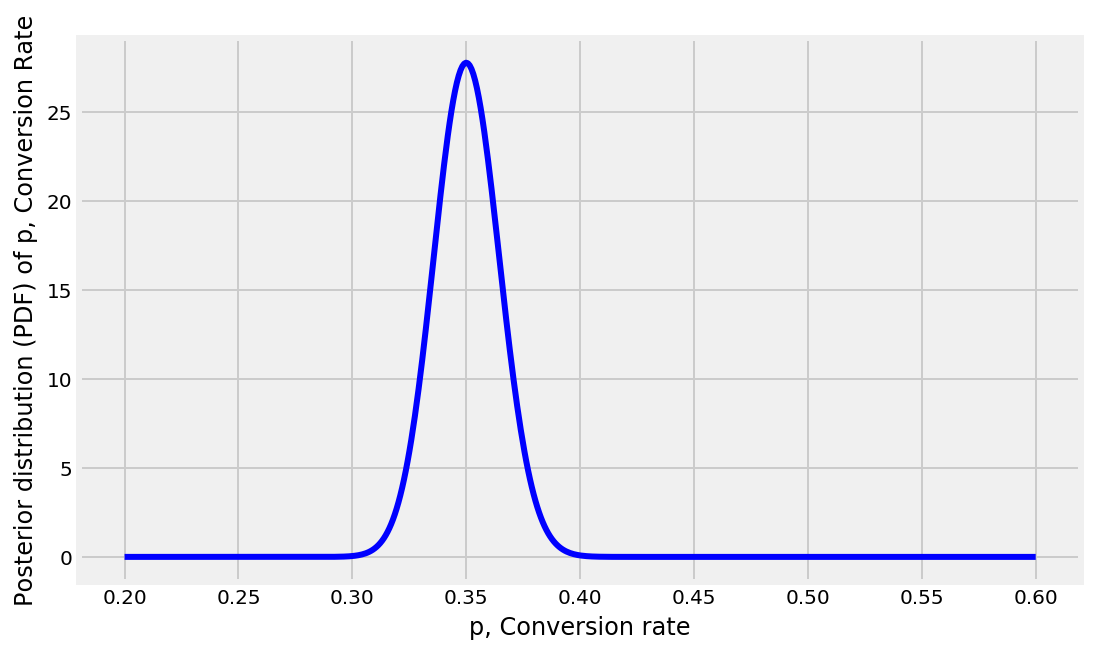

In [3]:
import scipy.stats as stats

alpha_prior = n_success_prior + 1
beta_prior = n_failures_prior + 1

alpha_post = k + alpha_prior   # this is not universal
beta_post = n - k + beta_prior  # this works b/c i have beta-binomial
                                # model (i.e. conjugacy)

pvals = np.linspace(0.2, 0.6, 500)    
beta_dist = stats.beta(alpha_post, beta_post)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(pvals, beta_dist.pdf(pvals), 'b', lw=3, label='Posterior')
ax.set_xlabel('p, Conversion rate')
ax.set_ylabel('Posterior distribution (PDF) of p, Conversion Rate')
plt.show()

In [4]:
import pymc3 as pm

Couldn't import dot_parser, loading of dot files will not be possible.


In [5]:
with pm.Model() as model:
    p = pm.Beta('p', alpha=alpha_prior, beta=beta_prior, testval='mean')
    y = pm.Binomial('y', n=n, p=p, observed=k)
    trace = pm.sample(2000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


TypeError: function() got an unexpected keyword argument 'njobs'

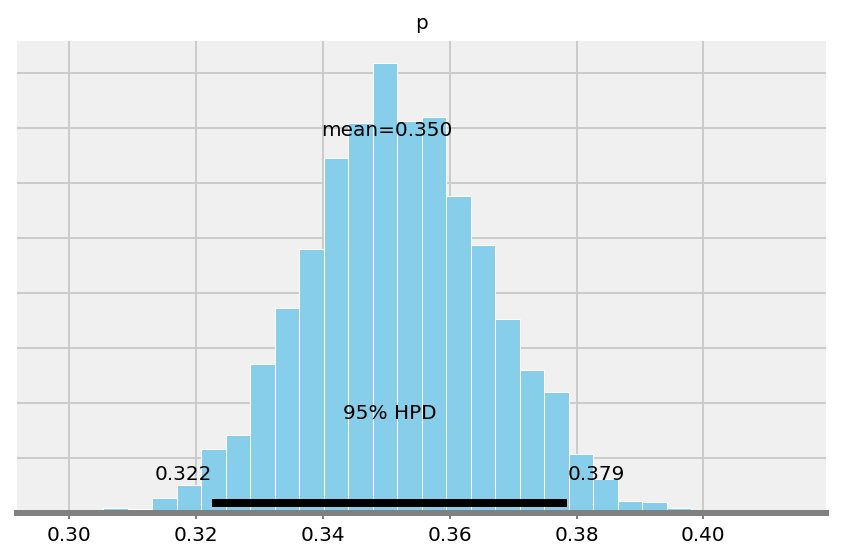

In [6]:
pm.plot_posterior(trace[200:],
                  varnames=['p'],
                  color='#87ceeb')

<a id='data'></a>
### Load the Starcraft dataset
---

You may be familiar with this dataset. It has records of different player statistics in competitive Starcraft. There are a variety of columns that are described in detail within the `description.txt` file contained inside the `./datasets/` folder.

For the examples in this lab, I will be using APM (actions per minute) and Age, but I in the following lab you will get the chance to look at other variables as well.

In [6]:
star = pd.read_csv('../datasets/SkillCraft1_Dataset.csv')

In [7]:
star.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [9]:
star.shape

(3395, 20)

<a id='reg'></a>
## Bayesian regression with `pymc3`
---

With `pymc3`, the sky is the limit. Let's move on to something a little more complicated: Bayesian regressions.

> *Note: [This example is modeled after the generalized linear model (GLM) instructions in the pymc3 documentation.](http://pymc-devs.github.io/pymc3/notebooks/GLM-linear.html)*

What are the benefits to taking a Bayesian approach to regression modeling? Just like in our estimation of means per group, when we perform regression with Bayesian statistics we will get out posterior *distributions* on our intercept and coefficients. 

This is a big difference from the point estimates coming out of the Frequentist regression: not only do we have the most likely value for the coefficients (the MAP estimates), we can see the range of possibilities given our prior and observed data. 

---

<a id='age-vs-apm'></a>
### Set up variables to perform an age vs. APM regression

In [10]:
star.Age.unique()

array(['27', '23', '30', '19', '32', '21', '17', '20', '18', '16', '26',
       '38', '28', '25', '22', '29', '24', '35', '31', '33', '37', '40',
       '34', '43', '41', '36', '44', '39', '?'], dtype=object)

In [11]:
s = star[star.Age != '?'].copy()
s['Age'] = s.Age.map(lambda x: float(x))

In [12]:
s.Age.mean()

21.647904191616767

In [14]:
s.shape

(3340, 20)

In [13]:
s.isnull().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

**Plot out the age vs. apm values.**

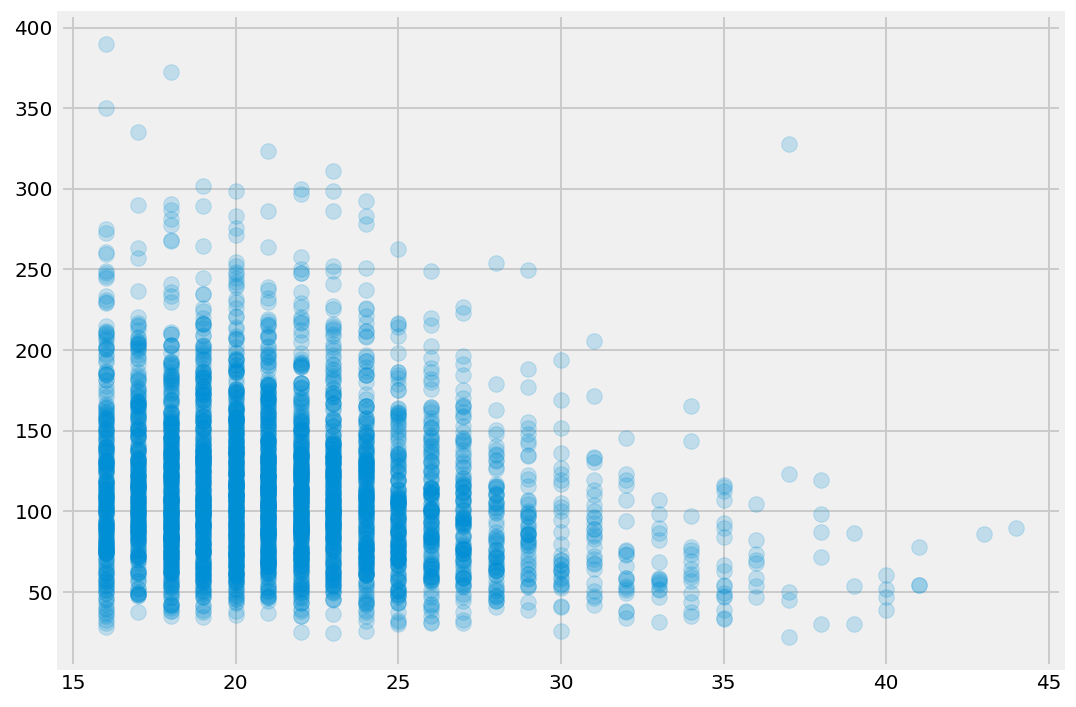

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(s.Age.values, s.APM.values, s=60, alpha=0.2)
plt.show()

<a id='bayes-model'></a>
### Setting up the Bayesian regression model

Remember regression?

## $$y = \beta_0 + \beta_1 x + \epsilon$$

From a statistical perspective, $\beta_0$, $\beta_1$ and $\epsilon$ are random variables.

For the sake of simplicity, let's assume that they are _uniform_ random variables.  This will be our prior belief, that will be updated based on data!

## $$\beta_0 \sim Uniform(-200, 200)$$

## $$\beta_1 \sim Uniform(-10000, 10000)$$

## $$\epsilon \sim Uniform(0.0001, 1000)$$


---

Like before, we will construct our model with the `with pm.Model() ...` syntax. 

We have three prior distributions in this case that will be updated to posteriors given our observed data:

1. `apm_std`: which will be our prior belief about the standard deviation of APM values. In this case I am setting it to be uniform (uninformative) between `0.0001`, and `1000.`
- `intercept`: a uniform distribution for the range of possible values of the intercept.
- `age_beta`: a uniform distribution for the range of possible values of the age coefficient.

We set up a `likelihood` distribution that is also normal, representing the distribution of the data (APM) given our predictor. The mean of the likelihood is defined like a regression formula: our intercept distribution plus the age values times our age beta distribution. We give the `apm_std` uniform prior as the standard deviation. Lastly, the observed values, or data, will be the APM values.

What will happen here as we sample from the posterior is that more likely values (as defined by the `mu=` regression-style definition) will be "visited" more often. The intercept and age_beta distributions will have more values visited in places where they result in higher likelihood estimates.

`pm.find_MAP()` tries to find good starting values for our sampling procedure so that we don't have to run it for as many iterations to get a good posterior representation.

In [16]:
apm_age = s[['APM','Age']]

In [17]:
with pm.Model() as reg:
    apm_std = pm.Uniform('apm_std', lower=0.0001, upper=1000.)
    intercept = pm.Uniform('intercept', lower=-10000., upper=10000.)
    age_beta = pm.Uniform('age_beta', lower=-200., upper=200.)
    
    # apm ~ b0 + b1 * age
    # E[apm]
    
    mu = intercept + (age_beta * apm_age.Age.values)
    E_apm = pm.Normal('y_mean', mu=mu,
                      sd=apm_std, observed=apm_age.APM.values)
    

In [18]:
with reg:
    step = pm.NUTS()
    start = pm.find_MAP()
    trace = pm.sample(4000, step=step, start=start)

/Users/gateam/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -17,623, ||grad|| = 0.93166: 100%|██████████| 32/32 [00:00<00:00, 416.93it/s]     
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [age_beta, intercept, apm_std]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:30<00:00, 296.31draws/s]


In [19]:
trace[0]

{'apm_std_interval__': -3.03401909757526,
 'intercept_interval__': 0.03132798954798055,
 'age_beta_interval__': -0.01898221979809641,
 'apm_std': 45.912546242512214,
 'intercept': 156.62713789968802,
 'age_beta': -1.8981649838462147}

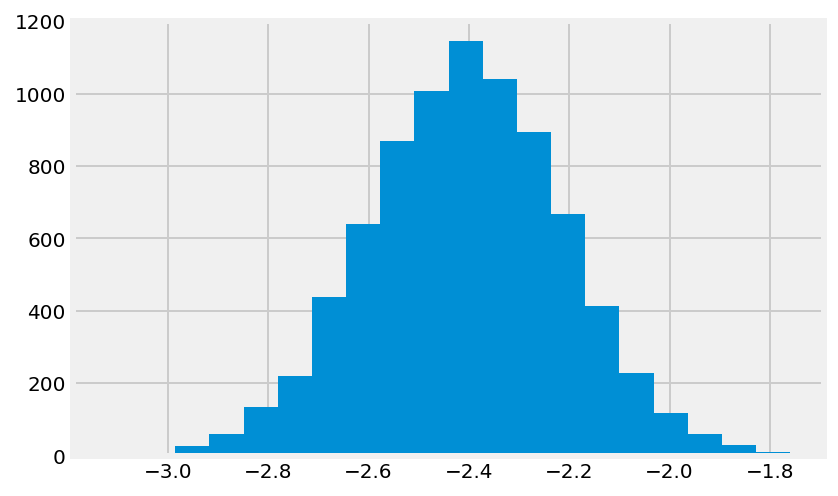

In [20]:
plt.hist(trace['age_beta'], bins=20);

In [21]:
beta_0_mean = np.mean(trace['intercept'])
beta_1_mean = np.mean(trace['age_beta'])

beta_0_low = np.percentile(trace['intercept'], 0.025)
beta_1_low = np.percentile(trace['age_beta'], 0.025)

beta_0_high = np.percentile(trace['intercept'], 0.975)
beta_1_high = np.percentile(trace['age_beta'], 0.975)

x = apm_age.Age.values
y = apm_age.APM.values

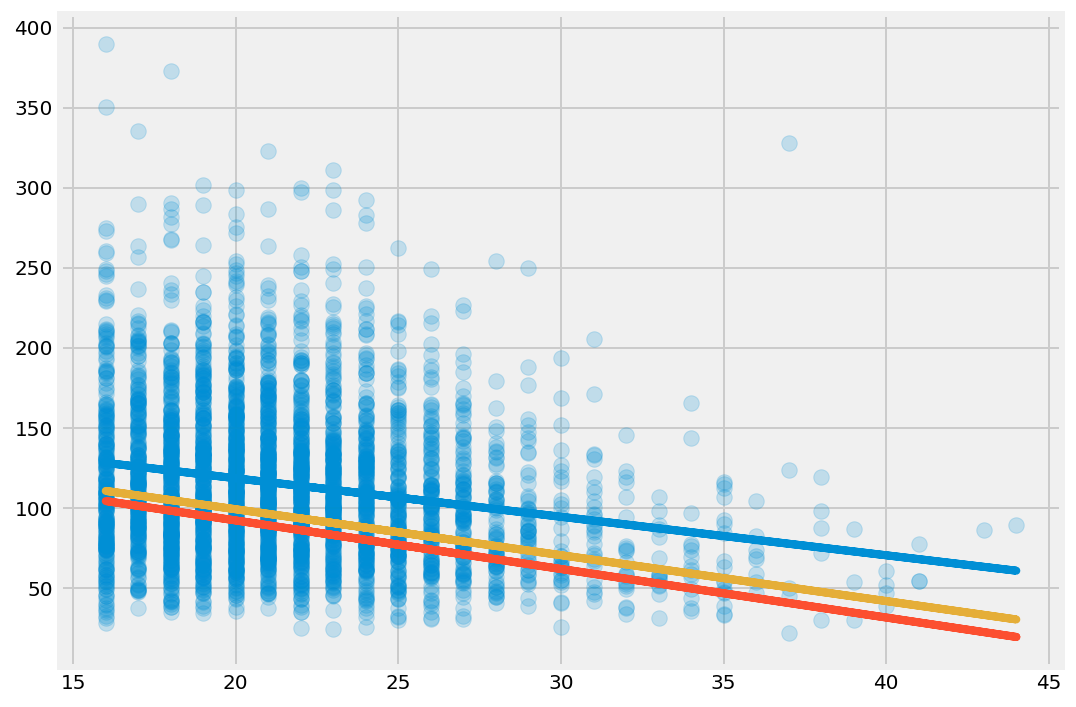

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x,y, s=60, alpha=0.2)
ax.plot(x, beta_0_mean + beta_1_mean*x) # Blue is mean
ax.plot(x, beta_0_low + beta_1_low*x) # Red is lower limit
ax.plot(x, beta_0_high + beta_1_high*x) # Yellow is the upper limit
plt.show()

<a id='traceplot'></a>
### Plot the posteriors using `pm.traceplot`

The traceplot function can also plot our posteriors, as well as a graph of the actual traces for each distribution. These traces represent the points visited by the sampling algorithm.

/Users/gateam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 504x504 with 0 Axes>

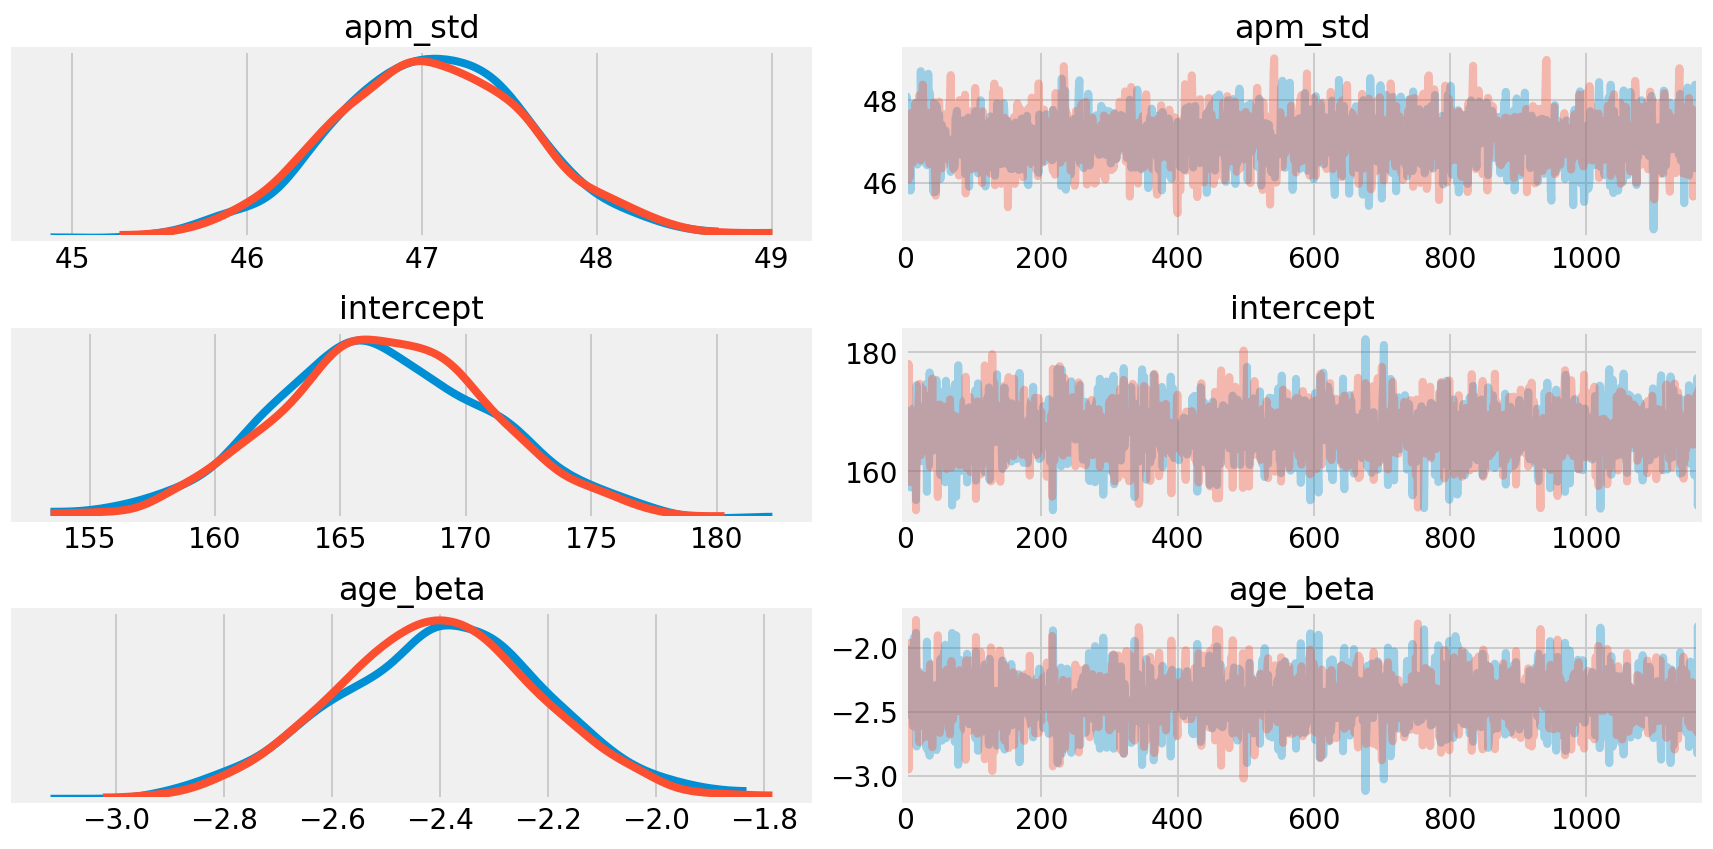

In [26]:
plt.figure(figsize=(7,7))
pm.traceplot(trace[500::3])
plt.tight_layout()

<a id='formula'></a>
## Setting up a model using a patsy-style formula
---

`pymc3` also provides a convenience function `pm.glm.glm(...` which takes a patsy-style formula definition and the dataframe, then automatically constructs the distributions required to solve the Bayesian regression. Pretty nice.

In [18]:
with pm.Model() as reg:
    pm.glm.GLM.from_formula('APM ~ Age', apm_age)
    start = pm.find_MAP()
    trace = pm.sample(3000, tune=1000, start=start)

logp = -17,613, ||grad|| = 0.011422: 100%|██████████| 43/43 [00:00<00:00, 1140.28it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, Age, Intercept]
100%|██████████| 4000/4000 [00:14<00:00, 283.71it/s]


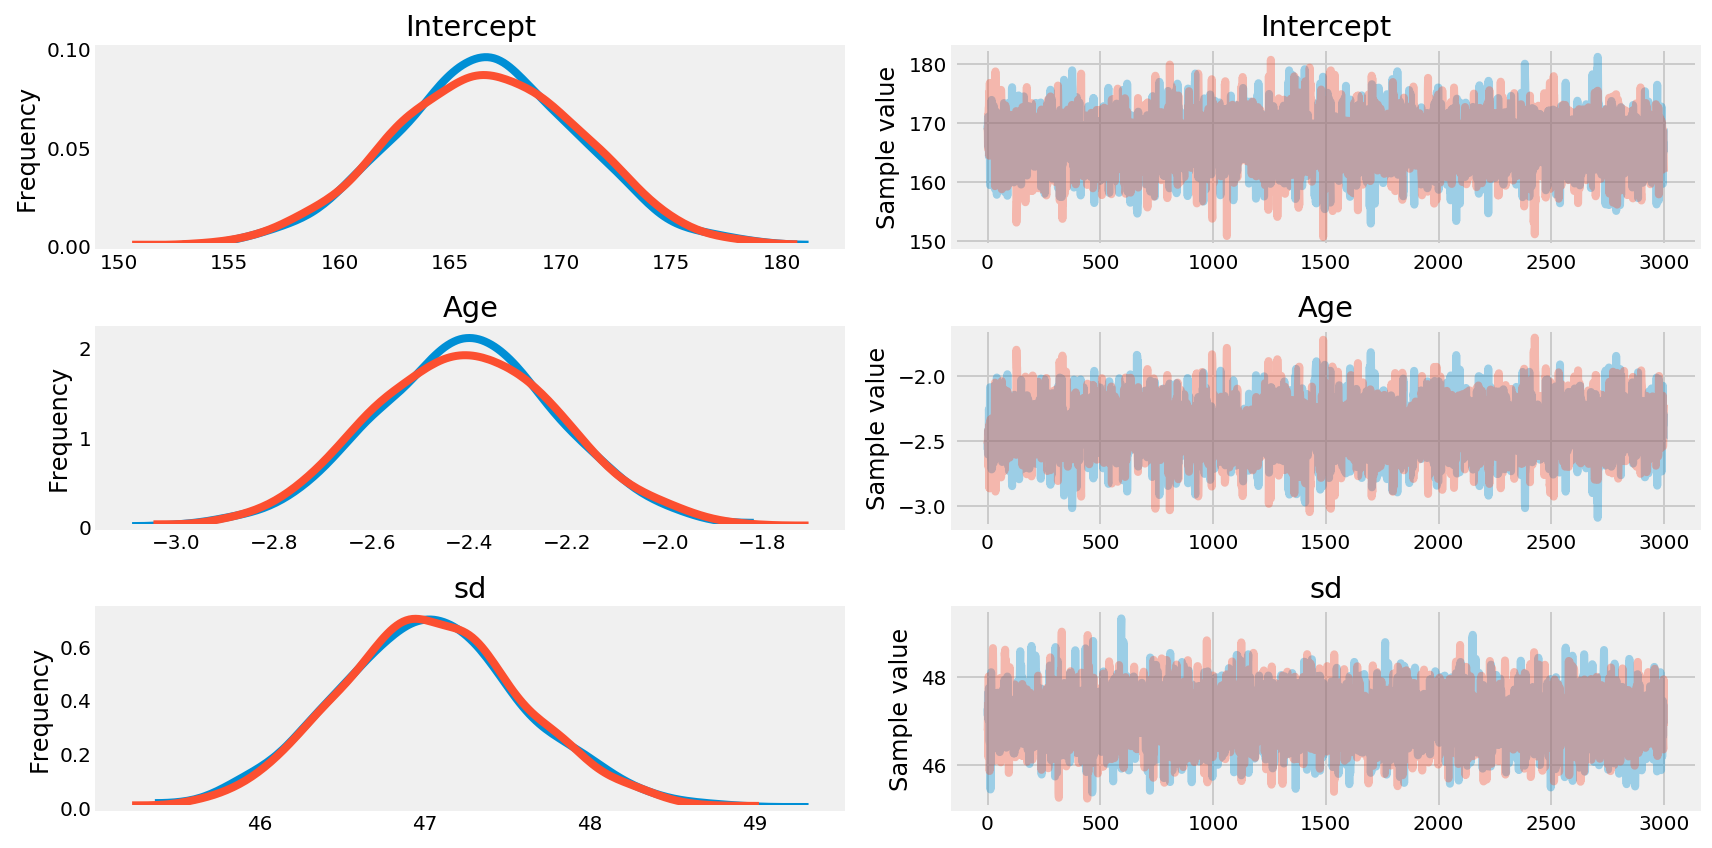

In [19]:
plt.figure(figsize=(7,7))
pm.traceplot(trace)
plt.tight_layout()

**Lastly, you can plot out different possible regression lines with `pm.glm.plot_posterior_predictive`.**

This function takes:

- the trace (MCMC samples)
- the number of samples you want to draw out and plot
- an `lm=` argument that will be a function defining how the regression line will be fit using an x value and the sample
- an `eval=` argument that will be the x-values `lm` is evaluated over

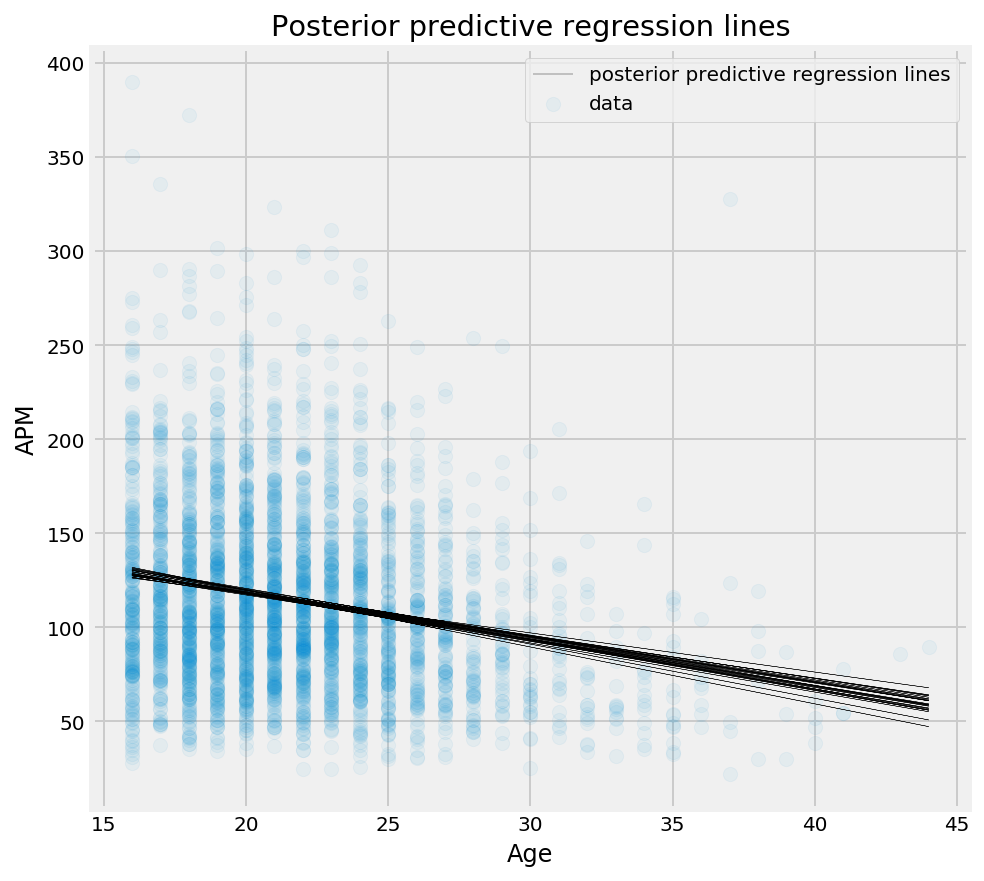

In [30]:
# A:
fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(apm_age.Age.values, apm_age.APM.values,
           s=50, alpha=0.05, label='data')

pm.plot_posterior_predictive_glm(trace, samples=25, 
                                 lm=lambda x, sample: sample['intercept'] + sample['age_beta']*x,
                                 eval=apm_age.Age.values,
                                 label='posterior predictive regression lines')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('Age')
plt.ylabel('APM')

plt.show()